In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_pat
import datetime
from scipy.interpolate import splev, splrep

%load_ext autoreload
%autoreload 2

In [2]:
from access_treasurydirectgov import *
import bond_analytics as ba
import bond_curve as bc
from db_manager_UST import *

In [3]:
myDB = db_manager_UST()

In [4]:
cob = datetime.datetime(2022, 6, 15)
df_cob = myDB.retrieve_as_of(cob)
df = df_cob[df_cob['type'].isin(bc.Conventional_Type)]
df = bc.yield_from_conventional(cob, df)
df.sort_values(by = 'Time-to-maturity', inplace=True)
df = df[df['Time-to-maturity'] > 0.25].copy()
df['Term-int'] = np.round(df['Term'])


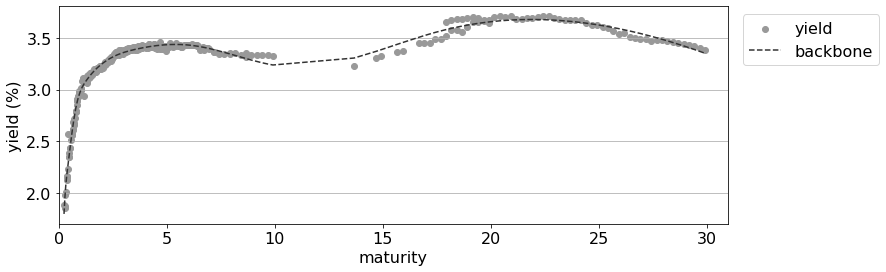

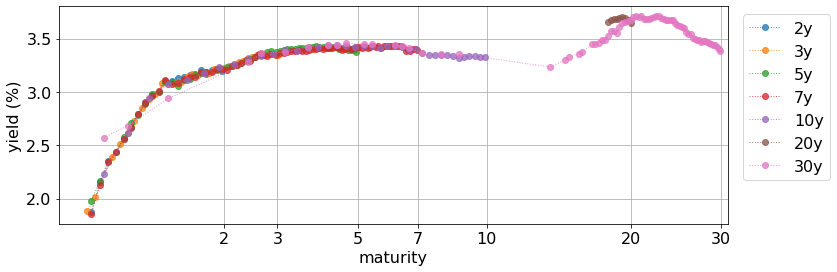

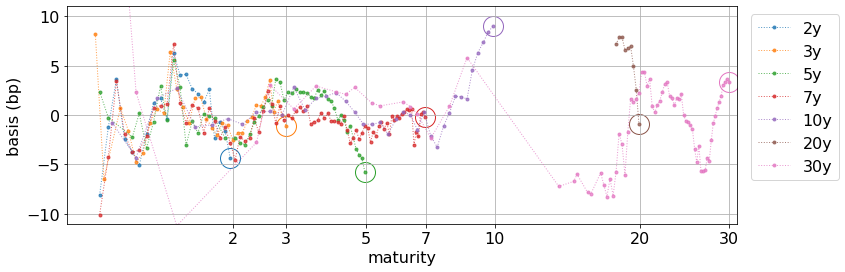

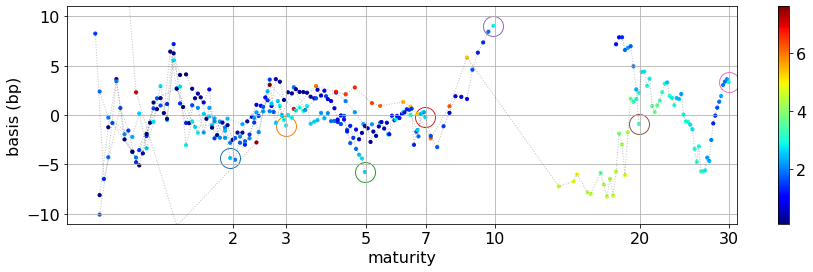

In [6]:
x = df['Time-to-maturity'].to_numpy()
y = df['Yield'].to_numpy() * 100

num_knots = 8
knots = np.exp(np.linspace(np.log(x[0]), np.log(x[-1]), num_knots+2))
spl = splrep(x, y, t = knots[1:-1])
m = splev(x, spl)

plt.rcParams['font.size'] = '16'

to_save = True

plt.figure(figsize=(12,4))
plt.scatter(x, y, color = np.ones(3)*0.6, marker = 'o', label='yield')
plt.plot(x, m, '--', color = np.ones(3)*0.2, label='backbone')
plt.xlabel('maturity'), plt.ylabel('yield (%)')
plt.xlim([0, 31])
plt.grid(axis='y')
plt.legend(bbox_to_anchor =(1.01, 1.0))
if to_save:
    plt.savefig('figs/yield.png',bbox_inches='tight')
plt.show()

fnTx = lambda x: np.log(x + 2)
x_ticks = np.array([2,3,5,7,10,20,30])
x_ticks_T = fnTx(x_ticks)
x_ticklabels = [str(t) for t in x_ticks]
xlim_T = fnTx(np.array([0, 31]))

plt.figure(figsize=(12,4))
for term, df_g in df.groupby('Term-int'):
    x_g = fnTx(df_g['Time-to-maturity'])
    y_g = df_g['Yield'] * 100
    line, = plt.plot(x_g, y_g, 'o:', lw=1, alpha = 0.75, label=str(int(term))+'y')

plt.xlabel('maturity'), plt.ylabel('yield (%)')
plt.xlim(xlim_T)
plt.grid()
plt.xticks(x_ticks_T, x_ticklabels)
plt.legend(bbox_to_anchor =(1.01, 1.0))
if to_save:
    plt.savefig('figs/yield-log.png',bbox_inches='tight')
plt.show()

df['Basis'] = 100 * (y - m)

plt.figure(figsize=(12,4))
for term, df_g in df.groupby('Term-int'):
    x_g = fnTx(df_g['Time-to-maturity'])
    y_g = df_g['Basis']

    line, = plt.plot(x_g, y_g, 'o:', ms=3, lw=1, alpha = 0.75, label=str(int(term))+'y')
    plt.plot(x_g[-1:], y_g[-1:], 'o', ms=20, markerfacecolor='None', c = line.get_color(), zorder=-10)
    #plt.scatter(x_g, y_g, marker = 'o', s = 8, c = line.get_color())#edgecolors=line.get_color(), facecolors="None")


plt.xlim(xlim_T), plt.ylim([-11, 11])
plt.xlabel('maturity'), plt.ylabel('basis (bp)')
plt.xticks(x_ticks_T, x_ticklabels)
plt.grid()
plt.legend(bbox_to_anchor =(1.01, 1.0))
if to_save:
    plt.savefig(os.path.join('figs', 'basis' + '.png'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(15,4))
x = fnTx(df['Time-to-maturity'])
y = df['Basis']
c = df['interestRate'] * 100
plt.scatter(x,y,c=c, cmap='jet', s=10)

for term, df_g in df.groupby('Term-int'):
    x_g = fnTx(df_g['Time-to-maturity'])
    y_g = df_g['Basis']
    line, = plt.plot(x_g, y_g, ':', c = 0.*np.ones(3), ms=3, lw=1, alpha = 0.25)
    plt.plot(x_g[-1:], y_g[-1:], 'o', ms=20, markerfacecolor='None', zorder=-10, label=str(int(term))+'y')

plt.colorbar()

plt.xlim(xlim_T), plt.ylim([-11, 11])
plt.xlabel('maturity'), plt.ylabel('basis (bp)')
plt.xticks(x_ticks_T, x_ticklabels)
plt.grid()
#plt.legend(bbox_to_anchor =(1.3, 1.0))
if to_save:
    plt.savefig(os.path.join('figs', 'basis-coupon' + '.png'),bbox_inches='tight')
plt.show()



In [13]:
for term, df_g in df.groupby('Term-int'):
    y_g = df_g['interestRate']
    print(term, y_g.to_numpy()[-1]*100)

2.0 2.5
3.0 2.875
5.0 2.625
7.0 2.75
10.0 2.875
20.0 3.25
30.0 2.875
